<h3 align="center">Computational Problem Set 7</h3> 

<h4 align="center">Kaitlyn Morrell</h4> 

In [1]:
# -*- coding: utf-8 -*-
%pylab notebook --no-import-all
%matplotlib notebook
import numpy as np
import sympy as sp
from sympy import *
import numpy.linalg as linalg
import scipy.sparse as sparse
import scipy.sparse.linalg as linalgs
from matplotlib import animation
from IPython.display import HTML

sp.init_printing(use_latex=True, use_unicode=True)

#from __future__ import division #don't need to distinguish floats from integers for division

Populating the interactive namespace from numpy and matplotlib


### Separation of Variables

We can use the method of separation of variables to analytically solve the differential equation $$\partial_t u(x,t) - \alpha\partial^2_x u(x,t) = 0 $$ by noting $$u(x,t) = v(t)w(x)$$ which gives $$\partial_t u(x,t) = \dot{v}w(x) \text{  and  } \partial^2_x u(x,t) = w^{''}v(t) $$ Plugging this into our initial equation gives $$\dot{v}w(x)-\alpha w^{''}v(t) = 0$$ $$\dot{v}w = \alpha w^{''}v$$ $$\frac{\dot{v}}{v} = \alpha\frac{w^{''}}{w}$$ We can solve for $v(t)$ and $w(x)$ by noticing that varying $t$ cannot change the right hand side and varying $x$ cannot change the left hand side. This implies $$\frac{\dot{v}}{v} = - c $$ $$\partial_t(\ln v(t)) = - c$$ $$\ln v(t) = - ct + K$$ $$v(t) = Ae^{- ct}$$  where $c$, $K$, and $A$ are constants that depend on initial conditions. Likewise, we can find an equation for $w(x)$: $$\alpha \frac{w^{''}}{w} = -c$$ $$w^{''} = -\frac{c}{\alpha}w$$ This is a familiar differential equation so we will assume the ansatz $w = B\cos(x\sqrt{c/\alpha})$ and find: $$w^{''} = -\frac{c}{\alpha}B\cos(x\sqrt{c/\alpha}) = -\frac{c}{\alpha}w$$ where $B$ and $c$ are constants determined by the boundary conditions. We can apply the boundary condition $\partial_x u(0,t)=\partial_x u(L,t) = 0$ where $L$ is the length of the rod: $$\partial_x u(L,t) = w' = -B\sin(L\sqrt{c/\alpha}) = 0$$ Assuming $B\neq 0$ $$L\sqrt{c/\alpha} = n\pi$$ $$c=\frac{n^2\pi^2\alpha}{L^2}$$. Combining solutions into one equation gives: $$u(x,t) = Ae^{-\frac{n^2\pi^2\alpha}{L^2}t}\cos(x\frac{n\pi}{L})$$

### Finite Difference Method

In [2]:
class HeatProb():
    """Class for setting up a heat equation eigenvector problem"""
    def alpha(self, x=None):
        """Return alpha at x"""
        return(1.) 
    def __init__(self, N=201, **kwargs): #can put any initial inputs when call class
        self.kwargs = kwargs
        self.N = N
        self.h = 1. / (np.float64(N) + 1.)
        self.x = (np.arange(self.N, dtype=np.float64) + 1.) * self.h #do i need this h here
        diagonal = 2. * np.ones(len(self.x))
        #diagonal[0] = diagonal[-1] = 4
        lower_diagonal = -1 * np.ones(len(self.x))
        upper_diagonal = -1 * np.ones(len(self.x))
        lower_diagonal[-2] = upper_diagonal[0] = 2
        self.A = (self.alpha(self.x) / self.h**2) * sparse.diags(diagonals=[lower_diagonal, diagonal, upper_diagonal],
                              offsets=[-1, 0, 1], shape=(N, N))
    def eig(self):
        # Note that the sparse version of "eig" failed here; I know this problem should 
        # yield sines and cosines. A lesson to check your package's performance! So I 
        # work on the full matrix.
        vals, vecs = linalg.eig(self.A.toarray())
        isort = np.argsort(vals)
        self.evals = vals[isort]
        self.evecs = vecs[:, isort]
    def set_coeffs(self, a=None, b=None):
        self.a = a
        self.b = b
    def fit_coeffs(self, d=None):
        """Fit coefficients for eigenvectors for a set of displacements"""
        (u, w, vt) = linalg.svd(self.evecs)
        inz = np.where(w > 1.e-15)[0]
        invw = np.zeros(len(w))
        invw[inz] = 1. / w[inz] 
        einv = vt.transpose().dot(np.diag(invw)).dot(u.transpose())
        return(einv.dot(d)) 
    def frame(self, i):
        period =  2. * np.pi / np.sqrt(self.evals[0])
        t = np.float64(i) / np.float64(nframes) * period * 4
        x = self.x
        coeffs = (self.a * np.cos(np.sqrt(self.evals) * t) +
                  self.b * np.sin(np.sqrt(self.evals) * t))
        y = self.evecs.dot(coeffs).flatten()
        line.set_data(x, y)
        return (line,)

In [3]:
class HeatProbTest():
    """Class for setting up a heat equation eigenvector problem"""
    def alpha(self, x=None):
        """Return alpha at x"""
        return(1.) 
    def __init__(self, N=201, **kwargs):
        self.kwargs = kwargs
        self.N = N
        self.h = 1. / (np.float64(N) + 1.)
        self.x = (np.arange(self.N, dtype=np.float64) + 1.) * self.h #do i need this h here
        diagonal = 2. * np.ones(len(self.x))
        #diagonal[0] = diagonal[-1] = 4
        lower_diagonal = -1 * np.ones(len(self.x))
        upper_diagonal = -1 * np.ones(len(self.x))
        lower_diagonal[-2] = upper_diagonal[0] = 2
        self.A = (self.alpha(self.x) / self.h**2) * sparse.diags(diagonals=[lower_diagonal, diagonal, upper_diagonal],
                              offsets=[-1, 0, 1], shape=(N, N))
    def eig(self):
        # Note that the sparse version of "eig" failed here; I know this problem should 
        # yield sines and cosines. A lesson to check your package's performance! So I 
        # work on the full matrix.
        vals, vecs = linalg.eig(self.A.toarray())
        isort = np.argsort(vals)
        self.evals = vals[isort]
        self.evecs = vecs[:, isort]
    def set_coeffs(self, a=None, b=None):
        self.a = a
        self.b = b
    def fit_coeffs(self, d=None):
        """Fit coefficients for eigenvectors for a set of displacements"""
        (u, w, vt) = linalg.svd(self.evecs)
        inz = np.where(w > 1.e-15)[0]
        invw = np.zeros(len(w))
        invw[inz] = 1. / w[inz] 
        einv = vt.transpose().dot(np.diag(invw)).dot(u.transpose())
        return(einv.dot(d)) 
    def frame(self, i):
        period =  2. * np.pi / np.sqrt(self.evals[0])
        t = np.float64(i) / np.float64(nframes) * period * 4
        x = self.x
        coeffs = (self.a * np.cos(np.sqrt(self.evals) * t) +
                  self.b * np.sin(np.sqrt(self.evals) * t))
        y = self.evecs.dot(coeffs).flatten()
        line.set_data(x, y)
        return (line,)

In [59]:
htN = HeatProbTest()
htN.eig()

In [39]:
htN.x

array([ 0.04761905,  0.0952381 ,  0.14285714,  0.19047619,  0.23809524,
        0.28571429,  0.33333333,  0.38095238,  0.42857143,  0.47619048,
        0.52380952,  0.57142857,  0.61904762,  0.66666667,  0.71428571,
        0.76190476,  0.80952381,  0.85714286,  0.9047619 ,  0.95238095])

In [58]:
ht= HeatProb()
ht.eig()

In [108]:
htT= HeatProbTest()
htT.eig()
print(htT.A.toarray())

[[ 81608. -40804.      0. ...,      0.      0.      0.]
 [-40804.  81608. -40804. ...,      0.      0.      0.]
 [     0. -40804.  81608. ...,      0.      0.      0.]
 ..., 
 [     0.      0.      0. ...,  81608. -40804.      0.]
 [     0.      0.      0. ..., -40804.  81608. -40804.]
 [     0.      0.      0. ...,      0. -40804.  81608.]]


<IPython.core.display.Javascript object>


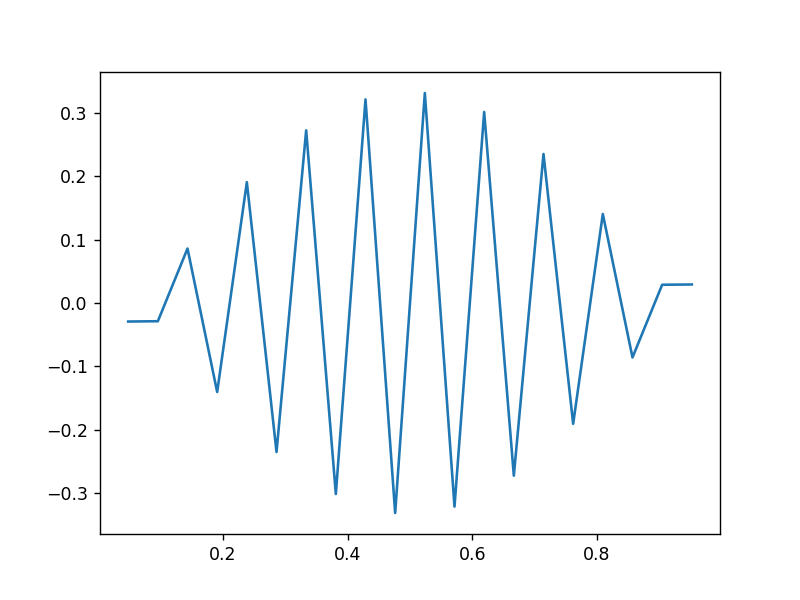

/home/kaitlyn/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [41]:
plt.figure()
plt.plot(htN.x, htN.evecs[:, -1])

<IPython.core.display.Javascript object>


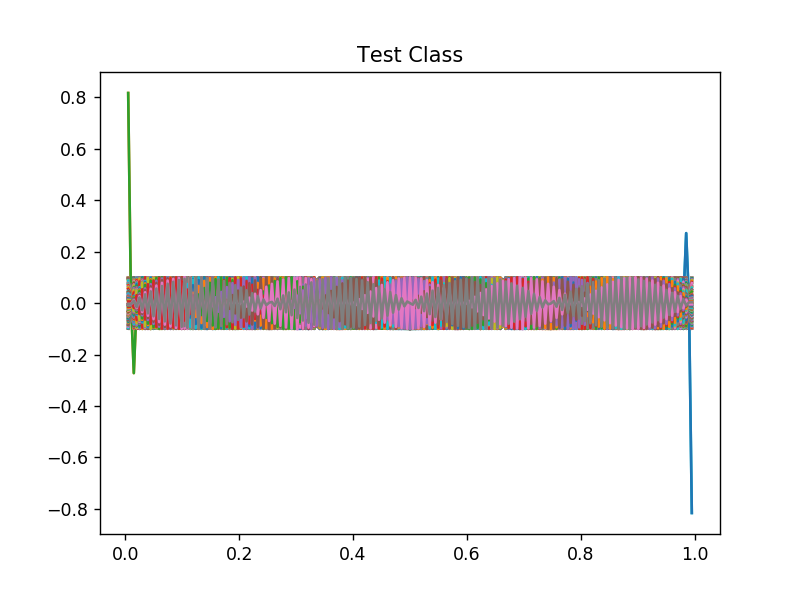

In [64]:
plt.figure()
plt.title('Test Class')
for i in np.arange(198):
    plt.plot(htN.x, htN.evecs[:, i], label='mode = %d' % (i))
#plt.legend()

<IPython.core.display.Javascript object>


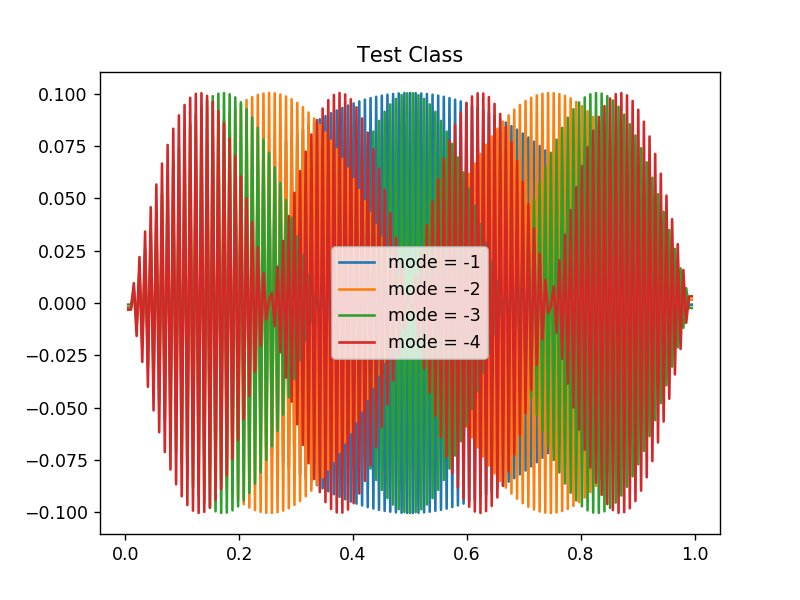

In [55]:
plt.figure()
plt.title('Test Class')
for i in np.arange(4)+1:
    plt.plot(htN.x, htN.evecs[:, -i], label='mode = %d' % (-i))
plt.legend()

<IPython.core.display.Javascript object>


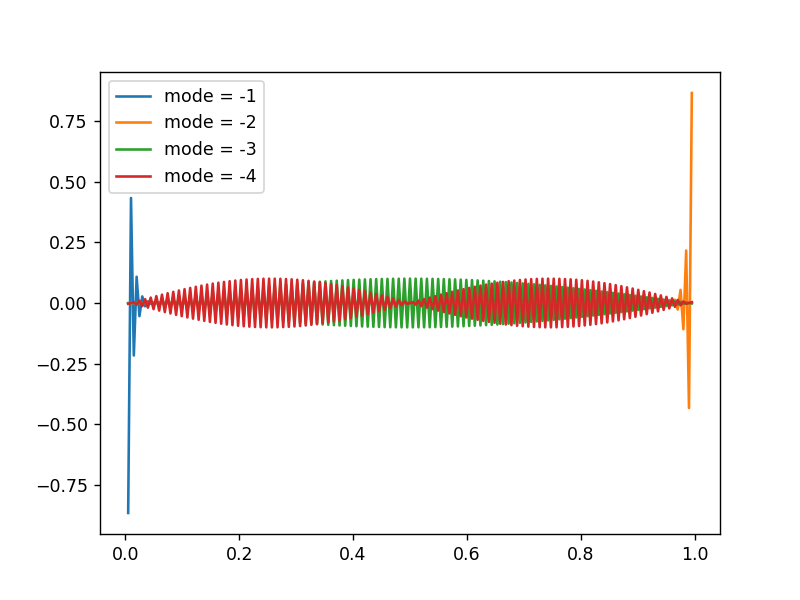

In [59]:
plt.figure()
for i in np.arange(4)+1:
    plt.plot(ht.x, ht.evecs[:, -i], label='mode = %d' % (-i))
plt.legend()

To investigate how the accuracy of the finite difference method varies with $N$, I compute the eigenvectors for various values of $N$ and plot a range of the resulting modes.

In [4]:
Ns = np.array([10, 70, 150, 200, 500])

In [5]:
ht1 = HeatProb(Ns[0])
ht1.eig()
ht2 = HeatProb(Ns[1])
ht2.eig()
ht3 = HeatProb(Ns[2])
ht3.eig()
ht4 = HeatProb(Ns[3])
ht4.eig()
ht5 = HeatProb(Ns[4])
ht5.eig()

<IPython.core.display.Javascript object>


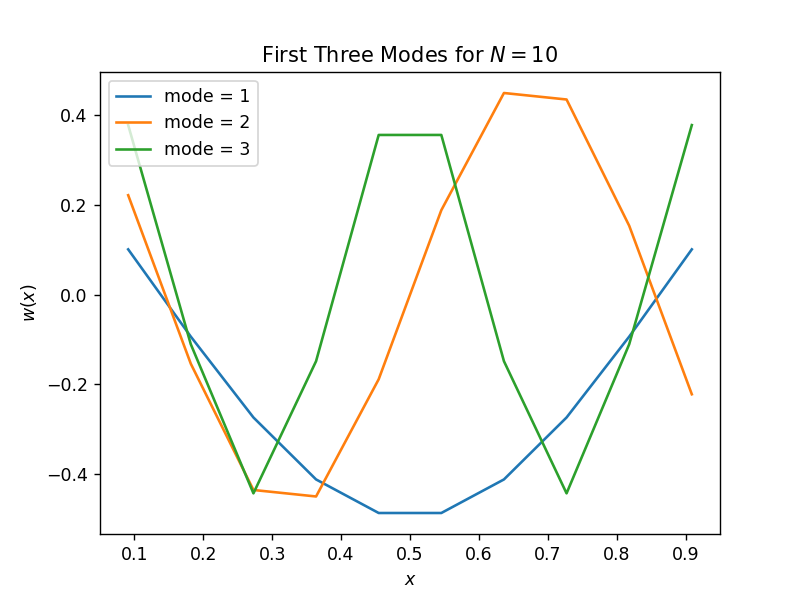

/home/kaitlyn/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


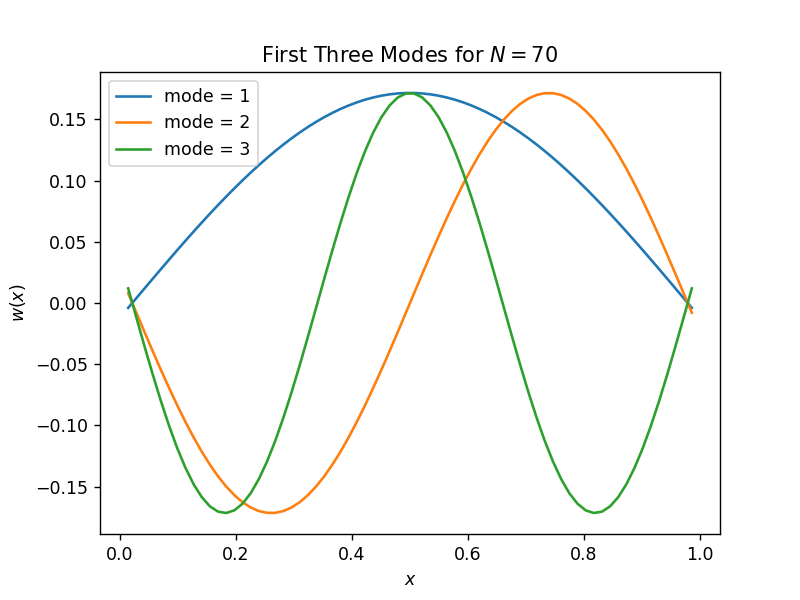

<IPython.core.display.Javascript object>


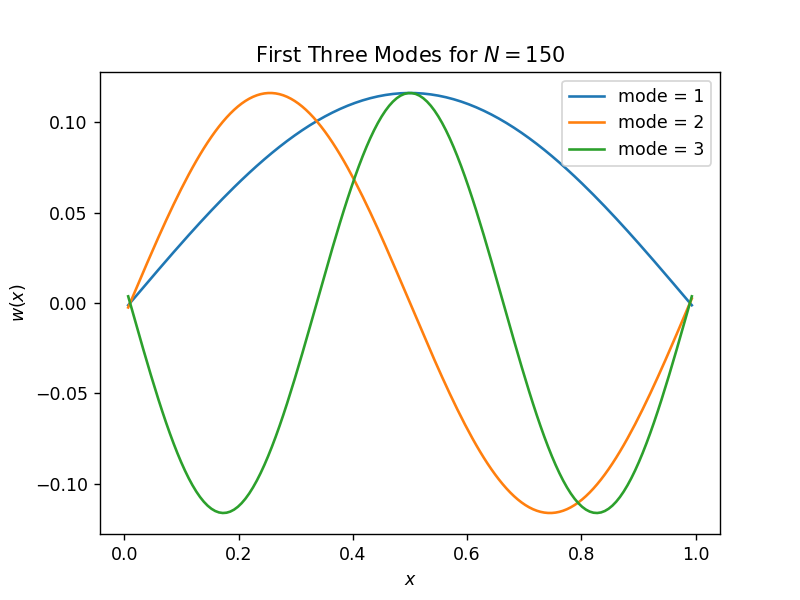

<IPython.core.display.Javascript object>


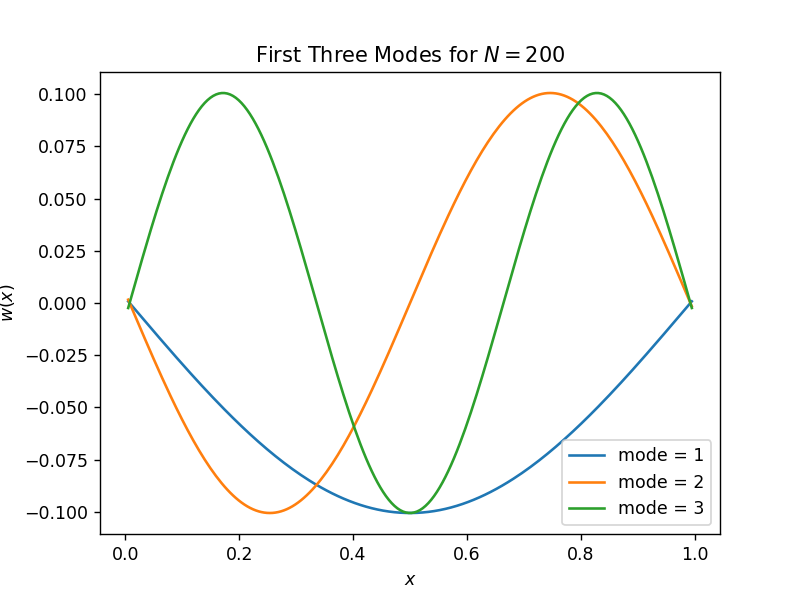

<IPython.core.display.Javascript object>


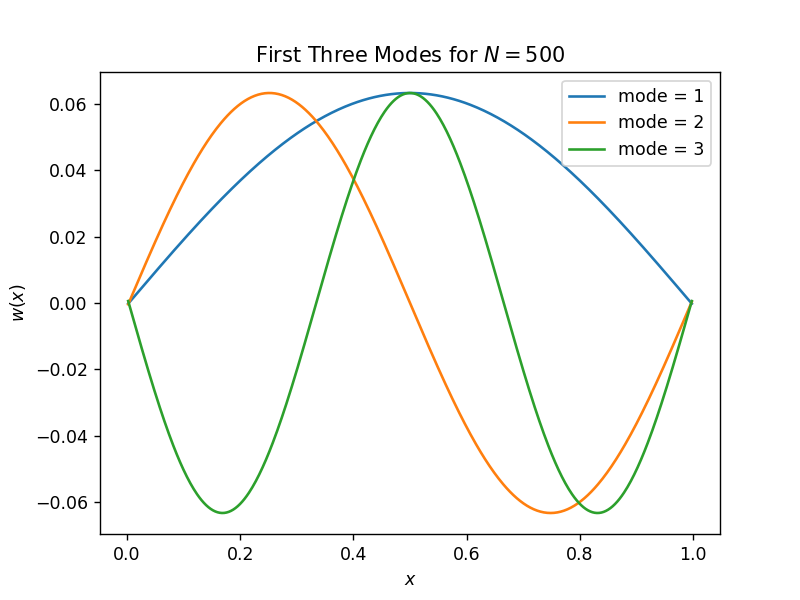

In [6]:
plt.figure()
plt.plot(ht1.x, ht1.evecs[:, 0], label='mode = %d' % (1))
plt.plot(ht1.x, ht1.evecs[:, 1], label='mode = %d' % (2))
plt.plot(ht1.x, ht1.evecs[:, 2], label='mode = %d' % (3))
plt.legend()
plt.title('First Three Modes for $N=%d$'% (Ns[0]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
plt.plot(ht2.x, ht2.evecs[:, 0], label='mode = %d' % (1))
plt.plot(ht2.x, ht2.evecs[:, 1], label='mode = %d' % (2))
plt.plot(ht2.x, ht2.evecs[:, 2], label='mode = %d' % (3))
plt.legend()
plt.title('First Three Modes for $N=%d$'% (Ns[1]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
plt.plot(ht3.x, ht3.evecs[:, 0], label='mode = %d' % (1))
plt.plot(ht3.x, ht3.evecs[:, 1], label='mode = %d' % (2))
plt.plot(ht3.x, ht3.evecs[:, 2], label='mode = %d' % (3))
plt.legend()
plt.title('First Three Modes for $N=%d$'% (Ns[2]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
plt.plot(ht4.x, ht4.evecs[:, 0], label='mode = %d' % (1))
plt.plot(ht4.x, ht4.evecs[:, 1], label='mode = %d' % (2))
plt.plot(ht4.x, ht4.evecs[:, 2], label='mode = %d' % (3))
plt.legend()
plt.title('First Three Modes for $N=%d$'% (Ns[3]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
plt.plot(ht5.x, ht5.evecs[:, 0], label='mode = %d' % (1))
plt.plot(ht5.x, ht5.evecs[:, 1], label='mode = %d' % (2))
plt.plot(ht5.x, ht5.evecs[:, 2], label='mode = %d' % (3))
plt.legend()
plt.title('First Three Modes for $N=%d$'% (Ns[4]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')

<IPython.core.display.Javascript object>


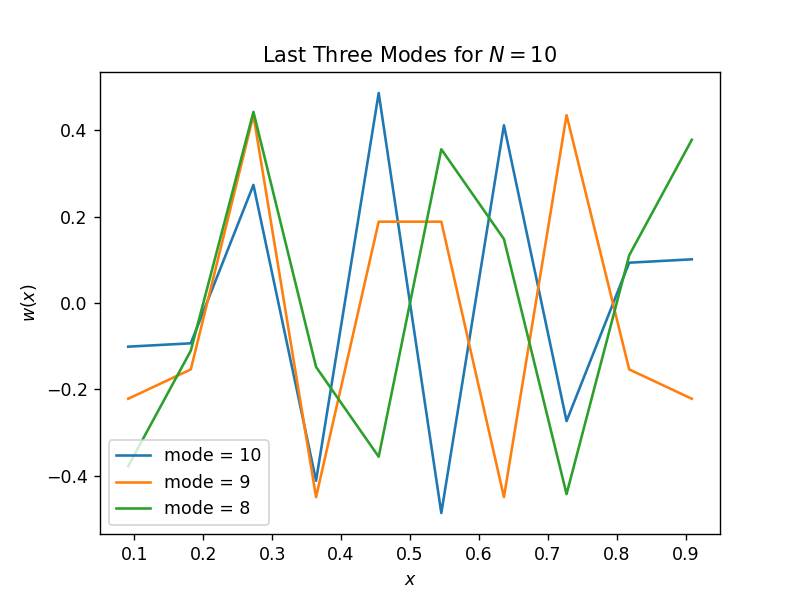

<IPython.core.display.Javascript object>


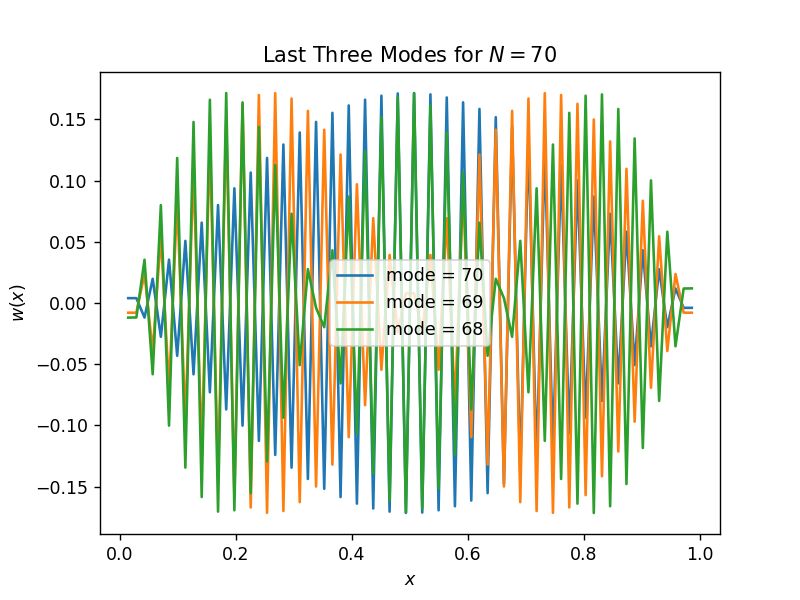

<IPython.core.display.Javascript object>


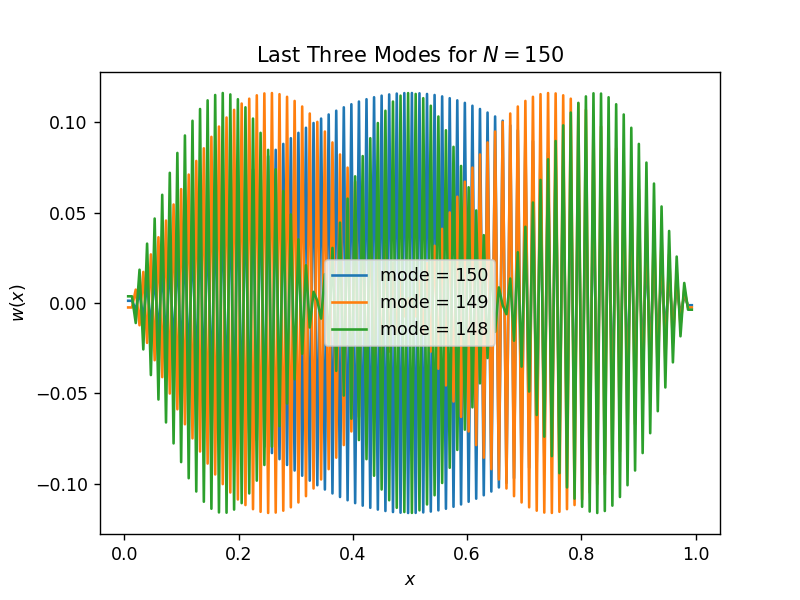

<IPython.core.display.Javascript object>


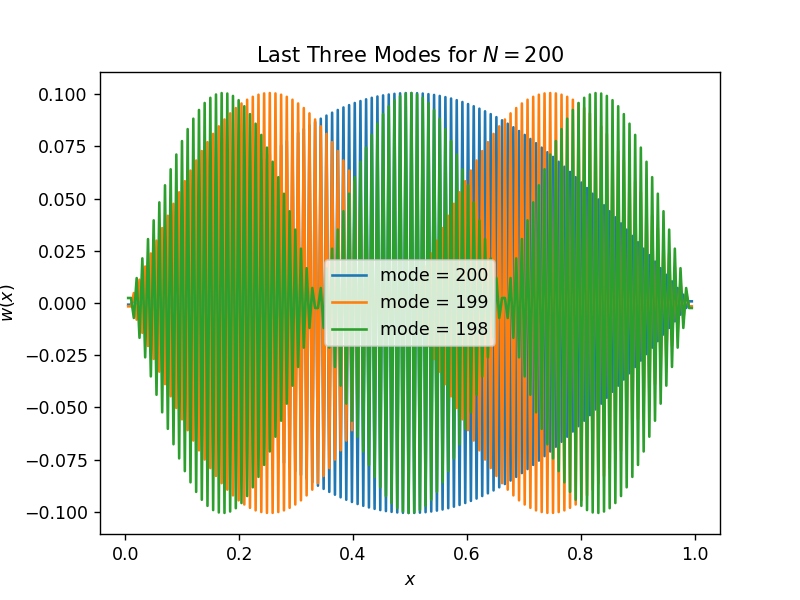

<IPython.core.display.Javascript object>


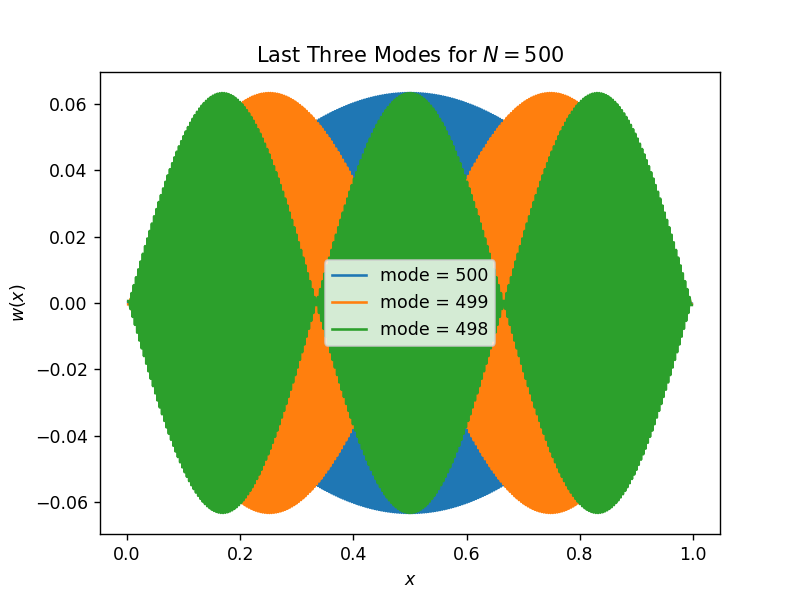

In [7]:
plt.figure()
plt.plot(ht1.x, ht1.evecs[:, -1], label='mode = %d' % (Ns[0]))
plt.plot(ht1.x, ht1.evecs[:, -2], label='mode = %d' % (Ns[0]-1))
plt.plot(ht1.x, ht1.evecs[:, -3], label='mode = %d' % (Ns[0]-2))
plt.legend()
plt.title('Last Three Modes for $N=%d$'% (Ns[0]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
plt.plot(ht2.x, ht2.evecs[:, -1], label='mode = %d' % (Ns[1]))
plt.plot(ht2.x, ht2.evecs[:, -2], label='mode = %d' % (Ns[1]-1))
plt.plot(ht2.x, ht2.evecs[:, -3], label='mode = %d' % (Ns[1]-2))
plt.legend()
plt.title('Last Three Modes for $N=%d$'% (Ns[1]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
plt.plot(ht3.x, ht3.evecs[:, -1], label='mode = %d' % (Ns[2]))
plt.plot(ht3.x, ht3.evecs[:, -2], label='mode = %d' % (Ns[2]-1))
plt.plot(ht3.x, ht3.evecs[:, -3], label='mode = %d' % (Ns[2]-2))
plt.legend()
plt.title('Last Three Modes for $N=%d$'% (Ns[2]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
plt.plot(ht4.x, ht4.evecs[:, -1], label='mode = %d' % (Ns[3]))
plt.plot(ht4.x, ht4.evecs[:, -2], label='mode = %d' % (Ns[3]-1))
plt.plot(ht4.x, ht4.evecs[:, -3], label='mode = %d' % (Ns[3]-2))
plt.legend()
plt.title('Last Three Modes for $N=%d$'% (Ns[3]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')
plt.figure()
plt.plot(ht5.x, ht5.evecs[:, -1], label='mode = %d' % (Ns[4]))
plt.plot(ht5.x, ht5.evecs[:, -2], label='mode = %d' % (Ns[4]-1))
plt.plot(ht5.x, ht5.evecs[:, -3], label='mode = %d' % (Ns[4]-2))
plt.legend()
plt.title('Last Three Modes for $N=%d$'% (Ns[4]))
plt.xlabel('$x$')
plt.ylabel('$w(x)$')

How does a central temperature excess evolve in time?

In [8]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

<IPython.core.display.Javascript object>


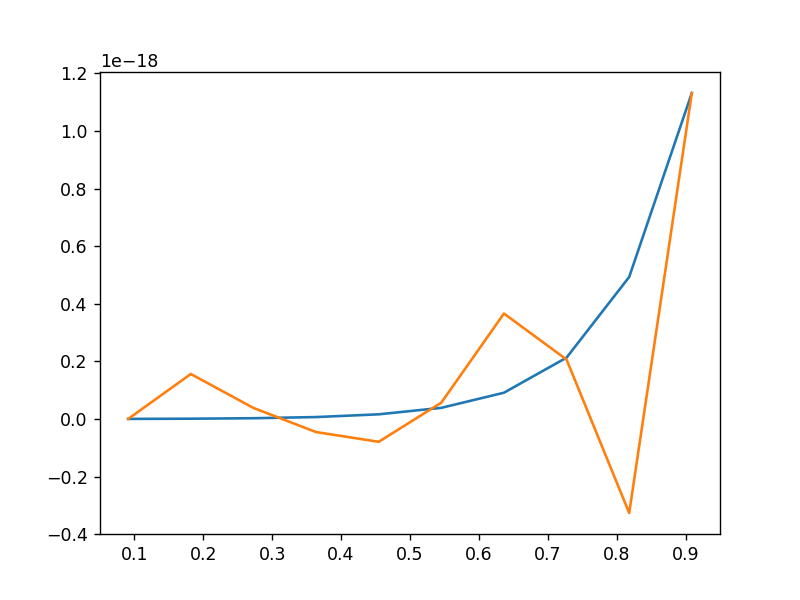

In [9]:
initial = gaussian(ht1.x, Ns[0], 1)
coeffs = ht1.fit_coeffs(d=initial)
plt.figure()
plt.plot(ht1.x, initial)
plt.plot(ht1.x, ht1.evecs.dot(coeffs))

<IPython.core.display.Javascript object>


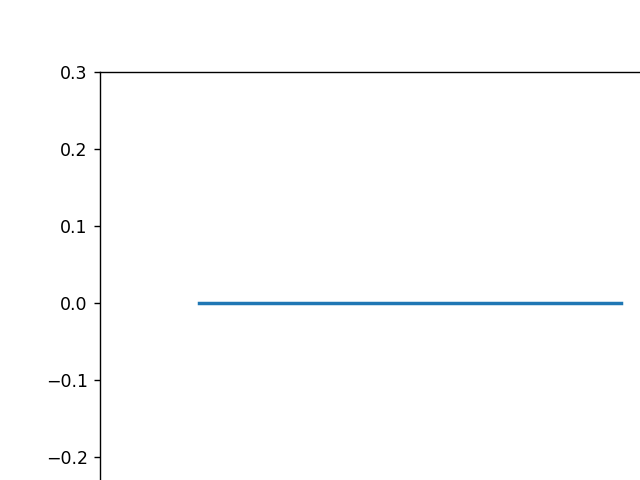

In [10]:
fig, ax = plt.subplots()

ax.set_xlim(( -0.1, 1.1))
ax.set_ylim((- 0.3, 0.3))

line, = ax.plot([], [], lw=2)

nframes = 500

def init():
    line.set_data([], [])
    return (line,)

In [11]:
bcoeffs = np.zeros(len(ht1.evals))
ht1.set_coeffs(a=coeffs, b=bcoeffs)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, ht1.frame, init_func=init,
                               frames=nframes, interval=40, blit=True)

HTML(anim.to_html5_video())